# Multi Armed Bandit
- 다양한 추천 시스템 모델을 동시에 사용할 때, 추천을 제공하는 매 순간마다 어떤 모델을 사용하는 것이 적절한지를 알려주는 알고리즘입니다.

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from google_drive_downloader import GoogleDriveDownloader as gdd
import matplotlib.pyplot as plt
import seaborn as sb

plt.style.use("dark_background")

- if_click_df는 각 모델에 대해서 추천한 아이템이 사용자의 클릭을 유도했는지 여부를 0과 1로 나타낸 가상의 데이터를 나타냅니다.

In [3]:
gdd.download_file_from_google_drive(file_id="1CmnFuDTSAaNxbZDkaBa1OtcVmTTnTsAY", dest_path="./MAB_simulation.csv")
if_click_df = pd.read_csv("MAB_simulation.csv")

In [4]:
if_click_df.head()

,TOP_K,CF,BPR
0,0,0,1
1,0,0,0
2,0,0,0
3,0,1,0
4,0,0,0


## Thompson Sampling 알고리즘

### Beta Distribution
- 베타 분포는 α와 β라는 두 parameter를 가지며 표본 공간은 0과 1 사이의 실수입니다.
- 10번 중 2번 클릭이 발생한 것과 100번 중 20번 클릭이 발생한 것은 둘 다 CTR이 0.2입니다.
- 그러나 전자보다 후자가 시행횟수가 많으므로 0.2라는 값에 대한 확신이 더 크다고 할 수 있습니다.
- beta distribution에서는 이를 서로 다른 probability density function(확률 밀도 함수) f로 나타냅니다.
$$
f(x;\ α,\ β)=\frac{1}{B(α,\ β)}x^{(α−1)}(1−x)^{(β−1)}
$$
- 기대값 E(x)
$$
E(x)=\frac{α}{α+β}
$$
- 분산 Var(x) : 확률분포의 폭
$$
Var(x)=\frac{αβ}{(α+β)^{2}(α+β+1)}
$$
- 최빈값 Mode(x) : 확률분포가 가장 커지는 위치
$$
Mode(x)=\frac{α−1}{α+β−2}
$$
- 다음 3가지 경우에 대해 probability density function을 그려보겠습니다.
    - case 1) 사용자에게 10번의 추천을 했을 때 2번 클릭한 경우
    - case 2) 사용자에게 100번의 추천을 했을 때 20번 클릭한 경우
    - case 3) 사용자에게 1000번의 추천을 했을 때 200번 클릭한 경우

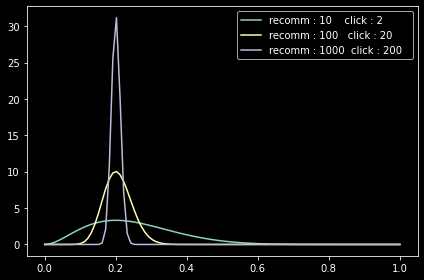

In [51]:
recomms = [10, 100, 1000]
clicks = [2, 20, 200]

fig, ax = plt.subplots()

for recomm, click in zip(recomms, clicks):
    #alpha, beta 대신에 a, b를 사용하겠습니다.
    a = click + 1
    b = recomm - click + 1

    ctr = (a-1) / (a+b-2) #mode
    var = (a*b) / ((a+b)**2*(a+b+1)) #var

    xs = np.linspace(0, 1, 100)
    ys = stats.beta.pdf(xs, a, b)
    
    sb.lineplot(ax=ax, x=xs, y=ys, label=f"recomm : {recomm:<5d} click : {click:<5d}")
fig.tight_layout()

### Thompson Sampling을 통해 CTR 추정하기

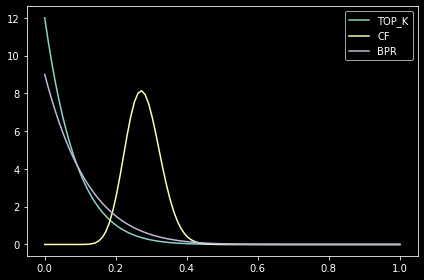

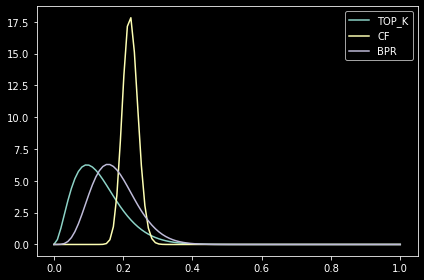

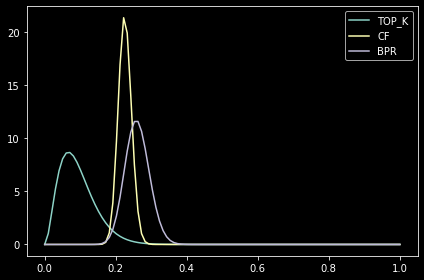

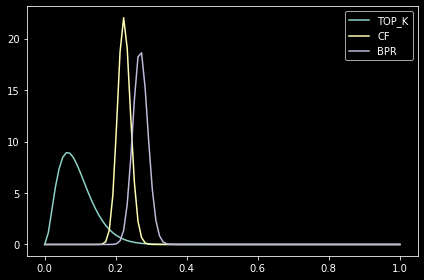

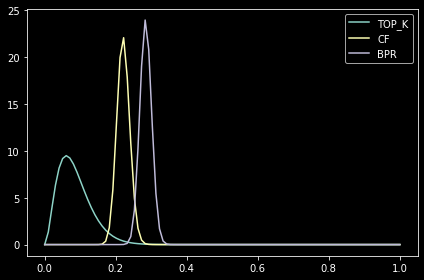

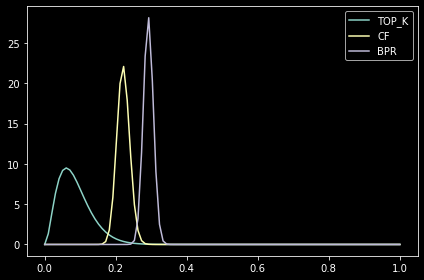

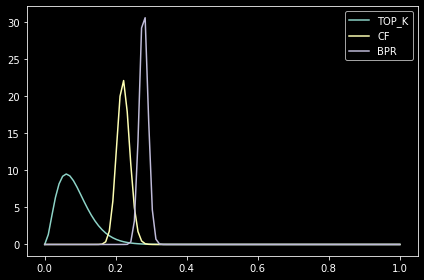

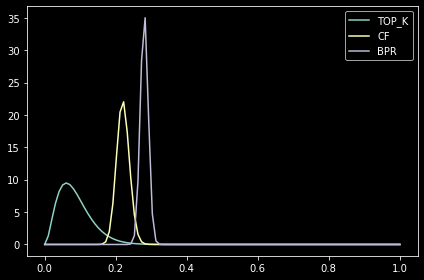

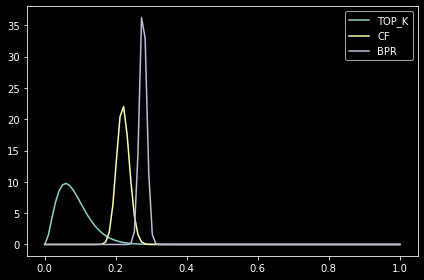

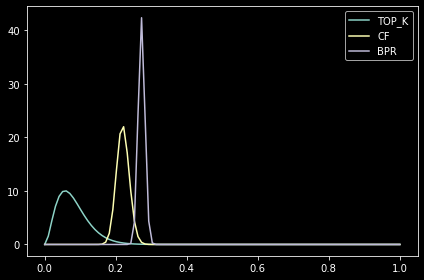

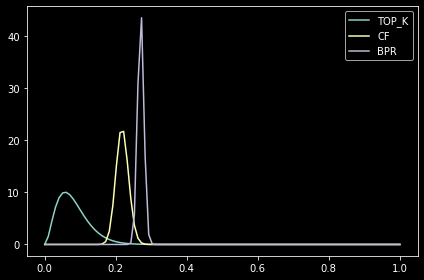

In [53]:
arms = pd.DataFrame(np.ones((3, 2)), index=["TOP_K", "CF", "BPR"], columns=["a", "b"])

tot_clicks = 0
for n_recomms in range(3101):
    #추천 수가 100, 400, 700, ...가 될 때마다
    if n_recomms % 300 == 100:
        fig, ax = plt.subplots()
        for name, row in arms.iterrows():
            xs = np.linspace(0, 1, 100)
            ys = stats.beta.pdf(xs, row["a"], row["b"])
            
            sb.lineplot(ax=ax, x=xs, y=ys, label=f"{name}")
            
            fig.tight_layout()
    #각 모델에서 probability density function에 기반하여 샘플링을 합니다.
    sample_res = {np.random.beta(row["a"], row["b"]):name for name, row in arms.iterrows()}
    #가장 큰 값을 갖는 샘플에 해당하는 묘델을 선택합니다.
    model_chosen = sample_res[max(sample_res)]
    
    #사용자가 클릭했는지 여부를 저장합니다.
    if_click = if_click_df.loc[n_recomms, model_chosen]
    tot_clicks += click
    
    if if_click:
        arms.loc[model_chosen, "a"] += 1
    else:
        arms.loc[model_chosen, "b"] += 1

In [54]:
arms

,a,b
TOP_K,3.0,34.0
CF,118.0,422.0
BPR,684.0,1846.0


In [56]:
#모델별 기대값
(arms["a"]) / (arms["a"] + arms["b"])

TOP_K    0.081081
CF       0.218519
BPR      0.270356
dtype: float64